# Comparing soundings from NCEP Reanalysis and various models

We are going to plot the global, annual mean sounding (vertical temperature profile) from observations.

Read in the necessary NCEP reanalysis data from the online server.

The catalog is here: <https://psl.noaa.gov/psd/thredds/catalog/Datasets/ncep.reanalysis.derived/catalog.html>

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

ncep_url = "https://psl.noaa.gov/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_air = xr.open_dataset( ncep_url + "pressure/air.mon.1981-2010.ltm.nc", decode_times=False)

In [2]:
level = ncep_air.level
lat = ncep_air.lat

Take global averages and time averages.

In [3]:
Tzon = ncep_air.air.mean(dim=('lon','time'))
weight = np.cos(np.deg2rad(lat)) / np.cos(np.deg2rad(lat)).mean(dim='lat')
Tglobal = (Tzon * weight).mean(dim='lat')

Here is code to make a nicely labeled sounding plot.

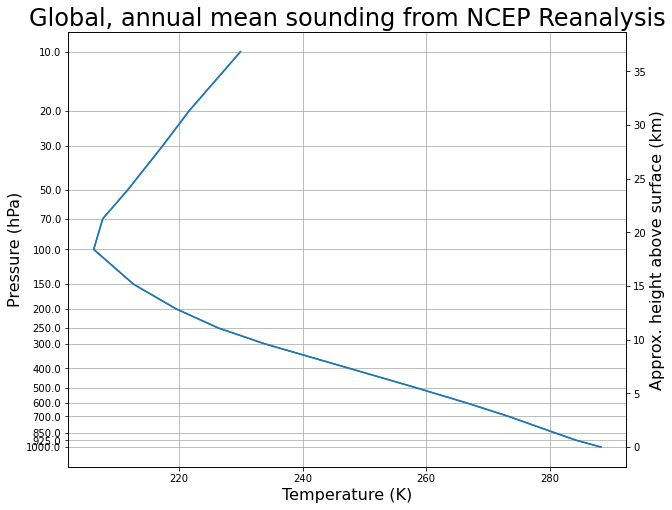

In [4]:
fig = plt.figure( figsize=(10,8) )
ax = fig.add_subplot(111)
ax.plot( Tglobal + 273.15, np.log(level/1000))
ax.invert_yaxis()
ax.set_xlabel('Temperature (K)', fontsize=16)
ax.set_ylabel('Pressure (hPa)', fontsize=16 )
ax.set_yticks( np.log(level/1000) )
ax.set_yticklabels( level.values )
ax.set_title('Global, annual mean sounding from NCEP Reanalysis', fontsize = 24)
ax2 = ax.twinx()
ax2.plot( Tglobal + 273.15, -8*np.log(level/1000) );
ax2.set_ylabel('Approx. height above surface (km)', fontsize=16 );
ax.grid()

## Now compute the Radiative Equilibrium solution for the grey-gas column model

In [5]:
import climlab
from climlab import constants as const

In [6]:
col = climlab.GreyRadiationModel()
print(col)

climlab Process of type <class 'climlab.model.column.GreyRadiationModel'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (30,) 
The subprocess tree: 
Untitled: <class 'climlab.model.column.GreyRadiationModel'>
   LW: <class 'climlab.radiation.greygas.GreyGas'>
   SW: <class 'climlab.radiation.greygas.GreyGasSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>



In [7]:
col.subprocess['LW'].diagnostics

{'flux_from_sfc': Field([0.]),
 'flux_to_sfc': Field([0.]),
 'flux_to_space': Field([0.]),
 'absorbed': Field([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'absorbed_total': Field([0.]),
 'emission': Field([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'emission_sfc': Field([0.]),
 'flux_reflected_up': None}

In [8]:
col.integrate_years(1)

print("Surface temperature is " + str(col.Ts) + " K.")
print("Net energy in to the column is " + str(col.ASR - col.OLR) + " W / m2.")

Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 0.9993368783782377 years.
Surface temperature is [287.84577808] K.
Net energy in to the column is [0.00165505] W / m2.


### Plot the radiative equilibrium temperature on the same plot with NCEP reanalysis

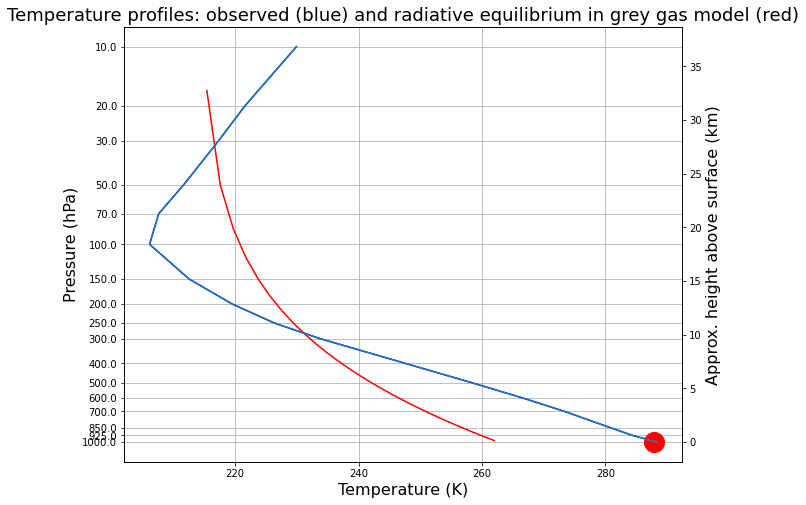

In [9]:
pcol = col.lev

fig = plt.figure( figsize=(10,8) )
ax = fig.add_subplot(111)
ax.plot( Tglobal + 273.15, np.log(level/1000), 'b-', col.Tatm, np.log( pcol/const.ps ), 'r-' )
ax.plot( col.Ts, 0, 'ro', markersize=20 )
ax.invert_yaxis()
ax.set_xlabel('Temperature (K)', fontsize=16)
ax.set_ylabel('Pressure (hPa)', fontsize=16 )
ax.set_yticks( np.log(level/1000) )
ax.set_yticklabels( level.values )
ax.set_title('Temperature profiles: observed (blue) and radiative equilibrium in grey gas model (red)', fontsize = 18)
ax2 = ax.twinx()
ax2.plot( Tglobal + const.tempCtoK, -8*np.log(level/1000) );
ax2.set_ylabel('Approx. height above surface (km)', fontsize=16 );
ax.grid()

## Now use convective adjustment to compute a Radiative-Convective Equilibrium temperature profile

In [10]:
dalr_col = climlab.RadiativeConvectiveModel(adj_lapse_rate='DALR')
print(dalr_col)

climlab Process of type <class 'climlab.model.column.RadiativeConvectiveModel'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (30,) 
The subprocess tree: 
Untitled: <class 'climlab.model.column.RadiativeConvectiveModel'>
   LW: <class 'climlab.radiation.greygas.GreyGas'>
   SW: <class 'climlab.radiation.greygas.GreyGasSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>



In [11]:
dalr_col.integrate_years(2.)

print("After " + str(dalr_col.time['days_elapsed']) + " days of integration:")
print("Surface temperature is " + str(dalr_col.Ts) + " K.")
print("Net energy in to the column is " + str(dalr_col.ASR - dalr_col.OLR) + " W / m2.")

Integrating for 730 steps, 730.4844 days, or 2.0 years.
Total elapsed time is 1.9986737567564754 years.
After 730.0 days of integration:
Surface temperature is [283.040058] K.
Net energy in to the column is [1.09588387e-06] W / m2.


In [12]:
dalr_col.param

{'timestep': 86400.0,
 'water_depth': 1.0,
 'albedo_sfc': 0.299,
 'Q': 341.3,
 'abs_coeff': 0.0001229,
 'adj_lapse_rate': 'DALR'}

Now plot this "Radiative-Convective Equilibrium" on the same graph:

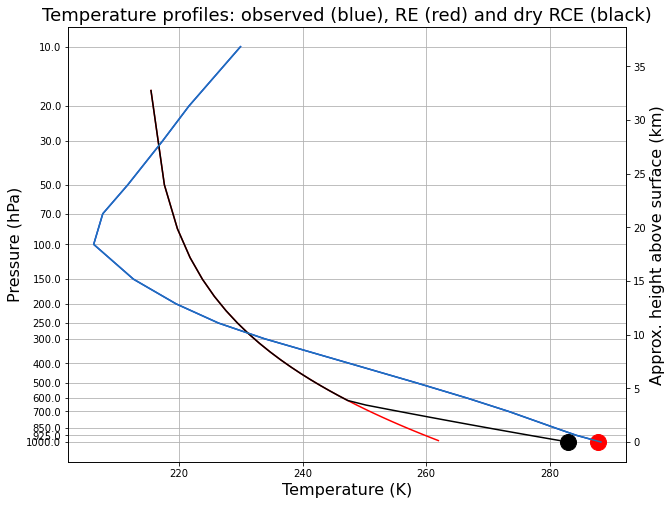

In [13]:
fig = plt.figure( figsize=(10,8) )
ax = fig.add_subplot(111)
ax.plot( Tglobal + 273.15, np.log(level/1000), 'b-', col.Tatm, np.log( pcol/const.ps ), 'r-' )
ax.plot( col.Ts, 0, 'ro', markersize=16 )
ax.plot( dalr_col.Tatm, np.log( pcol / const.ps ), 'k-' )
ax.plot( dalr_col.Ts, 0, 'ko', markersize=16 )
ax.invert_yaxis()
ax.set_xlabel('Temperature (K)', fontsize=16)
ax.set_ylabel('Pressure (hPa)', fontsize=16 )
ax.set_yticks( np.log(level/1000) )
ax.set_yticklabels( level.values )
ax.set_title('Temperature profiles: observed (blue), RE (red) and dry RCE (black)', fontsize = 18)
ax2 = ax.twinx()
ax2.plot( Tglobal + const.tempCtoK, -8*np.log(level/1000) );
ax2.set_ylabel('Approx. height above surface (km)', fontsize=16 );
ax.grid()

The convective adjustment gets rid of the unphysical temperature difference between the surface and the overlying air.

But now the surface is colder! Convection acts to move heat upward, away from the surface.

Also, we note that the observed lapse rate (blue) is always shallower than $\Gamma_d$ (temperatures decrease more slowly with height).

## "Moist" Convective Adjustment

To approximately account for the effects of latent heat release in rising air parcels, we can just adjust to a lapse rate that is a little shallow than $\Gamma_d$.

We will choose 6 K / km, which gets close to the observed mean lapse rate.

We will also re-tune the longwave absorptivity of the column to get a realistic surface temperature of 288 K:


In [14]:
rce_col = climlab.RadiativeConvectiveModel(adj_lapse_rate=6, abs_coeff=1.7E-4)
print(rce_col)

climlab Process of type <class 'climlab.model.column.RadiativeConvectiveModel'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (30,) 
The subprocess tree: 
Untitled: <class 'climlab.model.column.RadiativeConvectiveModel'>
   LW: <class 'climlab.radiation.greygas.GreyGas'>
   SW: <class 'climlab.radiation.greygas.GreyGasSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>



In [15]:
rce_col.integrate_years(2.)

print("After " + str(rce_col.time['days_elapsed']) + " days of integration:")
print("Surface temperature is " + str(rce_col.Ts) + " K.")
print("Net energy in to the column is " + str(rce_col.ASR - rce_col.OLR) + " W / m2.")

Integrating for 730 steps, 730.4844 days, or 2.0 years.
Total elapsed time is 1.9986737567564754 years.
After 730.0 days of integration:
Surface temperature is [287.9049635] K.
Net energy in to the column is [2.14745046e-06] W / m2.


Now add this new temperature profile to the graph:

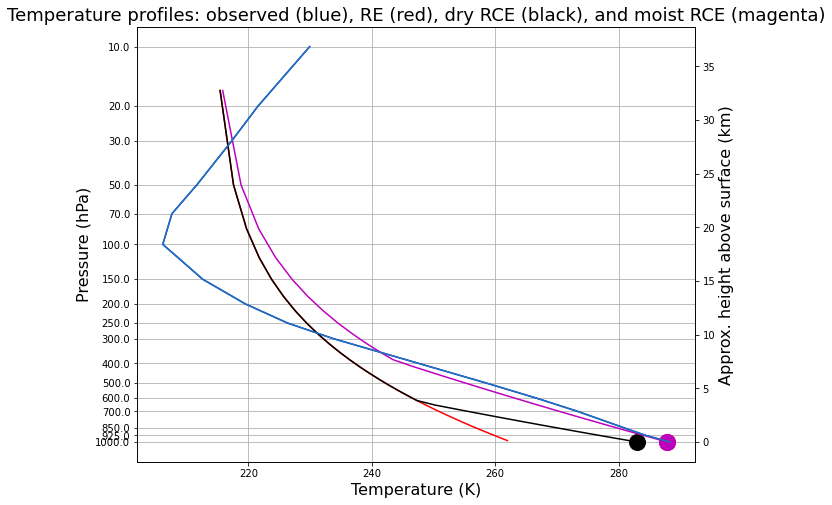

In [16]:
fig = plt.figure( figsize=(10,8) )
ax = fig.add_subplot(111)
ax.plot( Tglobal + 273.15, np.log(level/1000), 'b-', col.Tatm, np.log( pcol/const.ps ), 'r-' )
ax.plot( col.Ts, 0, 'ro', markersize=16 )
ax.plot( dalr_col.Tatm, np.log( pcol / const.ps ), 'k-' )
ax.plot( dalr_col.Ts, 0, 'ko', markersize=16 )
ax.plot( rce_col.Tatm, np.log( pcol / const.ps ), 'm-' )
ax.plot( rce_col.Ts, 0, 'mo', markersize=16 )
ax.invert_yaxis()
ax.set_xlabel('Temperature (K)', fontsize=16)
ax.set_ylabel('Pressure (hPa)', fontsize=16 )
ax.set_yticks( np.log(level/1000) )
ax.set_yticklabels( level.values )
ax.set_title('Temperature profiles: observed (blue), RE (red), dry RCE (black), and moist RCE (magenta)', fontsize = 18)
ax2 = ax.twinx()
ax2.plot( Tglobal + const.tempCtoK, -8*np.log(level/1000) );
ax2.set_ylabel('Approx. height above surface (km)', fontsize=16 );
ax.grid()

## Adding stratospheric ozone

Our model has no equivalent of the stratosphere, where temperature increases with height. That's because our model has been completely transparent to shortwave radiation up until now.

We can load some climatogical ozone data:

In [17]:
#  Put in some ozone
import xarray as xr

ozonepath = "http://thredds.atmos.albany.edu:8080/thredds/dodsC/CLIMLAB/ozone/apeozone_cam3_5_54.nc"
ozone = xr.open_dataset(ozonepath)
ozone

<xarray.Dataset>
Dimensions:    (lat: 64, lev: 59, lon: 128, time: 12)
Coordinates:
  * lev        (lev) float64 0.2842 0.3253 0.3719 ... 849.5 959.0 1.004e+03
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * time       (time) float64 4.382e+04 4.384e+04 ... 4.412e+04 4.415e+04
Data variables:
    P0         float64 ...
    date       (time) int32 ...
    datesec    (time) int32 ...
    OZONE_old  (time, lat, lev, lon) float64 ...
    OZONE      (time, lev, lat, lon) float64 ...
Attributes:
    Conventions:                     NCAR-CSM
    Source:                          AMIP II (symmetric for APE project)
    Written_By:                      olson
    Date_Written:                    August 22 2003
    Host:                            zen
    Command:                         ncgen
    history:                         Wed Jul 30 08:35:58 2008: ncrename -v OZ...
    DODS_EXTRA.Unlimited_Dimension:  time

Take the global average of the ozone climatology, and plot it as a function of pressure (or height)

In [18]:
# Taking annual, zonal, and global averages of the ozone data
O3_zon = ozone.OZONE.mean(dim=("time","lon"))

weight_ozone = np.cos(np.deg2rad(ozone.lat)) / np.cos(np.deg2rad(ozone.lat)).mean(dim='lat')
O3_global = (O3_zon * weight_ozone).mean(dim='lat')

In [19]:
O3_global.shape

(59,)

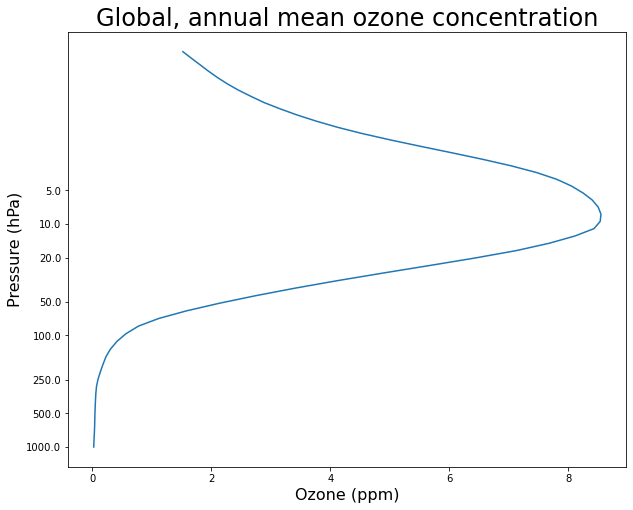

In [20]:
ax = plt.figure(figsize=(10,8)).add_subplot(111)
ax.plot( O3_global * 1.E6, np.log(O3_global.lev/const.ps) )
ax.invert_yaxis()
ax.set_xlabel('Ozone (ppm)', fontsize=16)
ax.set_ylabel('Pressure (hPa)', fontsize=16 )
yticks = np.array([1000., 500., 250., 100., 50., 20., 10., 5.])
ax.set_yticks( np.log(yticks/1000.) )
ax.set_yticklabels( yticks )
ax.set_title('Global, annual mean ozone concentration', fontsize = 24);

This shows that most of the ozone is indeed in the stratosphere, and peaks near the top of the stratosphere.

Now create a new column model object **on the same pressure levels as the ozone data**.  We are also going set an adjusted lapse rate of 6 K / km, and tune the longwave absorption 

In [21]:
oz_col = climlab.RadiativeConvectiveModel(lev = ozone.lev, 
                                          abs_coeff=1.82E-4, 
                                          adj_lapse_rate=6, 
                                          albedo=0.315)

Now we will do something new: let the column absorb some shortwave radiation. We will assume that the shortwave absorptivity is proportional to the ozone concentration we plotted above.  We need to weight the absorptivity by the pressure (mass) of each layer.

In [22]:
ozonefactor = 75
dp = oz_col.Tatm.domain.axes['lev'].delta
sw_abs = O3_global * dp * ozonefactor
oz_col.subprocess.SW.absorptivity = sw_abs
oz_col.compute()
oz_col.compute()
print(oz_col.SW_absorbed_atm)

[0.01521244 0.00239547 0.00294491 0.00359022 0.00437158 0.0053308
 0.006518   0.00801322 0.00983974 0.0122112  0.01517438 0.01896033
 0.02378877 0.03006126 0.03813404 0.04839947 0.06121356 0.07689825
 0.0956929  0.11774895 0.14311224 0.17200325 0.20535155 0.24420577
 0.28873387 0.33942617 0.39635885 0.45785715 0.51545681 0.57046196
 0.61908838 0.65388737 0.67529707 0.68302918 0.67627911 0.65546409
 0.61861086 0.56348381 0.48940972 0.40411693 0.32861214 0.27967132
 0.23974031 0.20685342 0.18078828 0.16426141 0.14274006 0.1154594
 0.09590159 0.09087993 0.09138546 0.09250529 0.09439986 0.09848981
 0.10256593 0.10092918 0.09452428 0.05852275 0.01312565]


Now run it out to Radiative-Convective Equilibrium, and plot

In [23]:
oz_col.integrate_years(2.)

print("After " + str(oz_col.time['days_elapsed']) + " days of integration:")
print("Surface temperature is " + str(oz_col.Ts) + " K.")
print("Net energy in to the column is " + str(oz_col.ASR - oz_col.OLR) + " W / m2.")

Integrating for 730 steps, 730.4844 days, or 2.0 years.
Total elapsed time is 1.9986737567564754 years.
After 730.0 days of integration:
Surface temperature is [289.52088978] K.
Net energy in to the column is [-9.48869513e-07] W / m2.


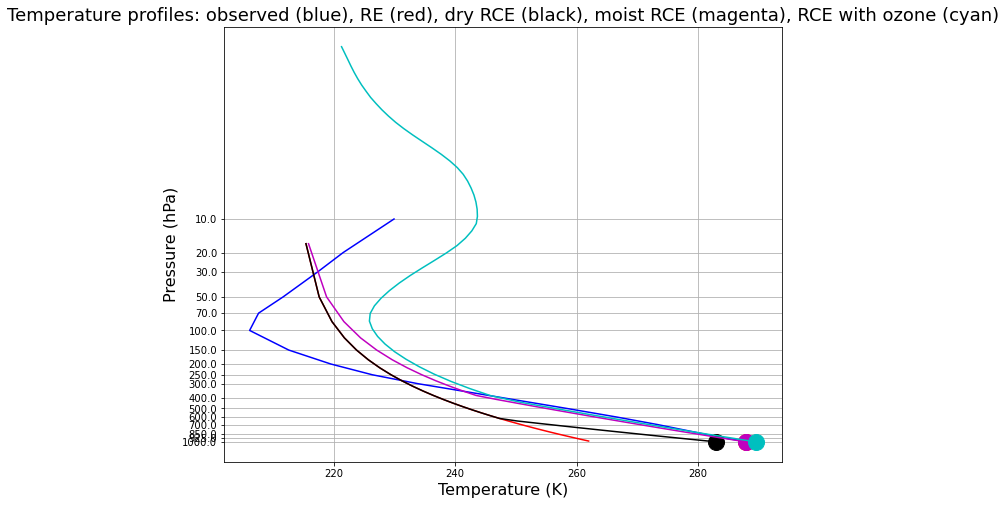

In [24]:
pozcol = oz_col.lev

fig = plt.figure( figsize=(10,8) )
ax = fig.add_subplot(111)
ax.plot( Tglobal + const.tempCtoK, np.log(level/1000), 'b-', col.Tatm, np.log( pcol/const.ps ), 'r-' )
ax.plot( col.Ts, 0, 'ro', markersize=16 )
ax.plot( dalr_col.Tatm, np.log( pcol / const.ps ), 'k-' )
ax.plot( dalr_col.Ts, 0, 'ko', markersize=16 )
ax.plot( rce_col.Tatm, np.log( pcol / const.ps ), 'm-' )
ax.plot( rce_col.Ts, 0, 'mo', markersize=16 )
ax.plot( oz_col.Tatm, np.log( pozcol / const.ps ), 'c-' )
ax.plot( oz_col.Ts, 0, 'co', markersize=16 )
ax.invert_yaxis()
ax.set_xlabel('Temperature (K)', fontsize=16)
ax.set_ylabel('Pressure (hPa)', fontsize=16 )
ax.set_yticks( np.log(level/1000) )
ax.set_yticklabels( level.values )
ax.set_title('Temperature profiles: observed (blue), RE (red), dry RCE (black), moist RCE (magenta), RCE with ozone (cyan)', fontsize = 18)
ax.grid()

And we finally have something that looks looks like the tropopause, with temperature increasing above at about the correct rate. Though the tropopause temperature is off by 15 degrees or so.

## Greenhouse warming in the RCE model with ozone

In [25]:
oz_col2 = climlab.process_like( oz_col )

In [26]:
oz_col2.subprocess['LW'].absorptivity *= 1.2 

In [27]:
oz_col2.integrate_years(2.)

Integrating for 730 steps, 730.4844 days, or 2.0 years.
Total elapsed time is 3.997347513512951 years.


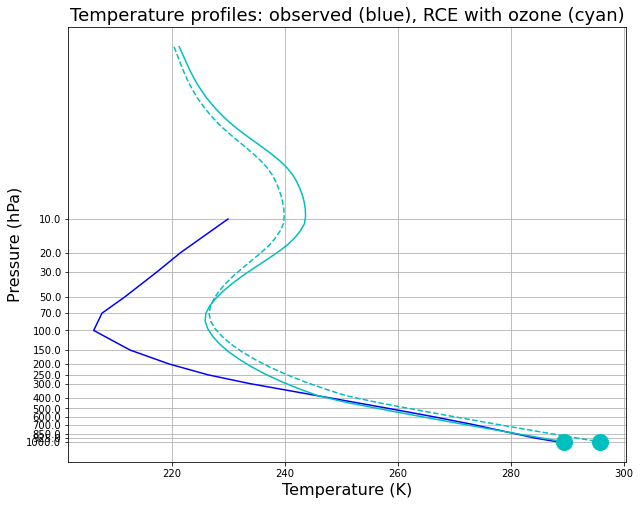

In [28]:
fig = plt.figure( figsize=(10,8) )
ax = fig.add_subplot(111)
ax.plot( Tglobal + const.tempCtoK, np.log(level/const.ps), 'b-' )
ax.plot( oz_col.Tatm, np.log( pozcol / const.ps ), 'c-' )
ax.plot( oz_col.Ts, 0, 'co', markersize=16 )
ax.plot( oz_col2.Tatm, np.log( pozcol / const.ps ), 'c--' )
ax.plot( oz_col2.Ts, 0, 'co', markersize=16 )
ax.invert_yaxis()
ax.set_xlabel('Temperature (K)', fontsize=16)
ax.set_ylabel('Pressure (hPa)', fontsize=16 )
ax.set_yticks( np.log(level/const.ps) )
ax.set_yticklabels( level.values )
ax.set_title('Temperature profiles: observed (blue), RCE with ozone (cyan)', fontsize = 18)
ax.grid()

And we find that the troposphere warms, while the stratosphere cools!

### Vertical structure of greenhouse warming in CESM model

In [29]:
datapath = "http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/"
atmstr = ".cam.h0.clim.nc"

cesm_ctrl = xr.open_dataset(datapath + 'som_1850_f19/clim/som_1850_f19' + atmstr)
cesm_2xCO2 = xr.open_dataset(datapath + 'som_1850_2xCO2/clim/som_1850_2xCO2' + atmstr)

In [30]:
cesm_ctrl.T

<xarray.DataArray 'T' (time: 12, lev: 26, lat: 96, lon: 144)>
[4313088 values with dtype=float32]
Coordinates:
  * lev      (lev) float64 3.545 7.389 13.97 23.94 ... 867.2 929.6 970.6 992.6
  * time     (time) object 0001-01-15 00:00:00 ... 0001-12-15 00:00:00
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    mdims:         1
    units:         K
    long_name:     Temperature
    cell_methods:  time: mean time: mean

In [31]:
T_cesm_ctrl_zon = cesm_ctrl.T.mean(dim=('time', 'lon'))
T_cesm_2xCO2_zon = cesm_2xCO2.T.mean(dim=('time', 'lon'))

In [32]:
weight = np.cos(np.deg2rad(cesm_ctrl.lat)) / np.cos(np.deg2rad(cesm_ctrl.lat)).mean(dim='lat')

T_cesm_ctrl_glob = (T_cesm_ctrl_zon*weight).mean(dim='lat')
T_cesm_2xCO2_glob = (T_cesm_2xCO2_zon*weight).mean(dim='lat')

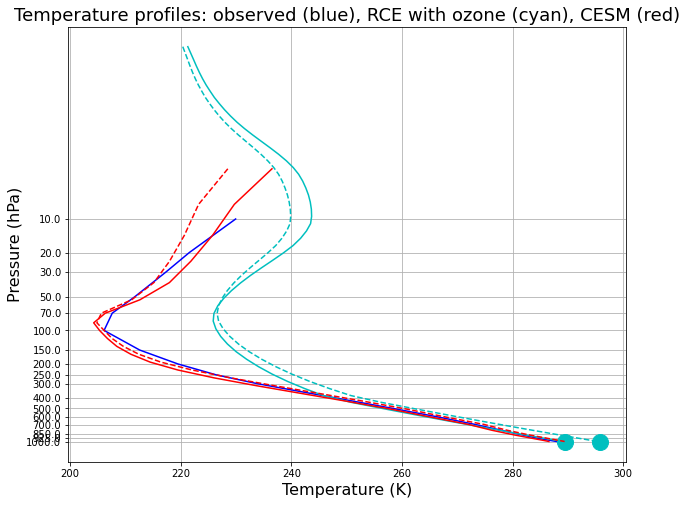

In [33]:
fig = plt.figure( figsize=(10,8) )
ax = fig.add_subplot(111)
ax.plot( Tglobal + const.tempCtoK, np.log(level/const.ps), 'b-' )
ax.plot( oz_col.Tatm, np.log( pozcol / const.ps ), 'c-' )
ax.plot( oz_col.Ts, 0, 'co', markersize=16 )
ax.plot( oz_col2.Tatm, np.log( pozcol / const.ps ), 'c--' )
ax.plot( oz_col2.Ts, 0, 'co', markersize=16 )
ax.plot( T_cesm_ctrl_glob, np.log( cesm_ctrl.lev/const.ps ), 'r-' )
ax.plot( T_cesm_2xCO2_glob, np.log( cesm_ctrl.lev/const.ps ), 'r--' )
ax.invert_yaxis()
ax.set_xlabel('Temperature (K)', fontsize=16)
ax.set_ylabel('Pressure (hPa)', fontsize=16 )
ax.set_yticks( np.log(level/const.ps) )
ax.set_yticklabels( level.values )
ax.set_title('Temperature profiles: observed (blue), RCE with ozone (cyan), CESM (red)', fontsize = 18)
ax.grid()

And we find that CESM has the same tendency for increased CO2: warmer troposphere, colder stratosphere.